## Load modules and data

In [1]:
#Base
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
from statsmodels.stats.multitest import fdrcorrection
import ray

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis.correlation import calculate_correlation, ProgressBar

#Network 
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities, naive_greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

#CCM
from delay_embedding import surrogate as S
from delay_embedding import helpers as H

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)



In [3]:
##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


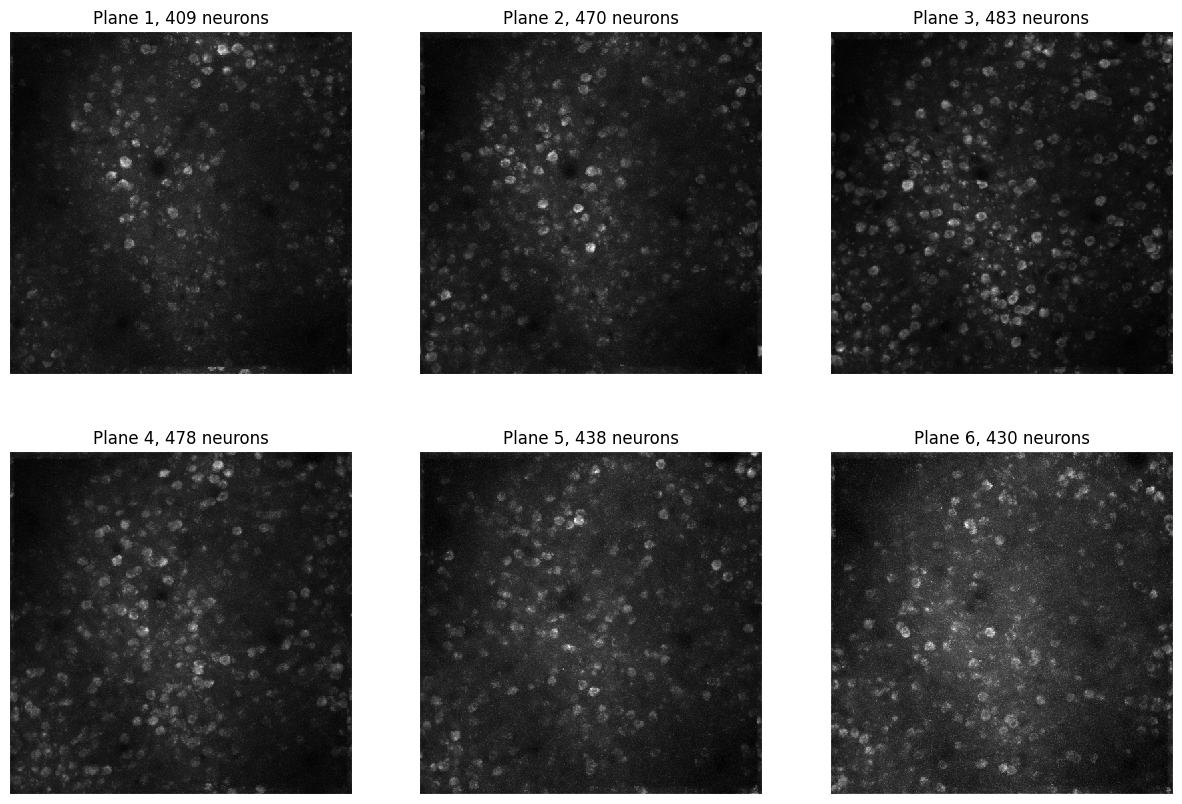

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

## Load data from all planes
data_dict = {plane: {} for plane in sess.get_planes()}
for ii, plane in enumerate(sess.get_planes()):
    # #Get dff traces
    # dff_full, ts_full = sess.get_traces(plane, trace_type='events')

    #Only take valid cells
    mask = sess.is_roi_valid(plane)
    indy = np.where(mask)[0]

    # #Subsample
    # dff = dff_full[indy]; ts = ts_full
    roi_ids = np.array(sess.get_rois(plane))
    roi_ids_valid = roi_ids[indy]

    # data_dict[plane]['dff'] = dff
    # data_dict[plane]['ts'] = ts

    ##Get image
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

    # valid = sess.is_roi_valid(plane); indy = np.where(valid)[0]
    # mask = sess.get_roi_image_mask(plane, np.array(sess.get_rois(plane))[indy])

    ax = axes[ii//3,ii%3]; ax.axis('off')
    # ax.imshow(np.ma.masked_where(~mask,proj_de_max), cmap='viridis', interpolation='nearest')
    ax.imshow(proj_raw_max, cmap='gray', interpolation='nearest')
    ax.set_title(f'Plane {plane}, {roi_ids_valid.shape[0]} neurons')

plt.savefig(os.path.join(PlotDir,'example_2p_recording.png'))


In [4]:
## Interpolate all planes to same time
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='dff',reload=True)

#Get number of neurons per plane
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane

del data_list_interp



In [5]:
from glob import glob
file_list = sorted(glob('/home/david.wyrick/projects/V1DD/data/predictions_dff_409828_13*'))


data_list = []
ts_list = []
stim_list = []
for fpath in file_list:
    stim = fpath[64:-4]
    data = np.load(fpath)
    spike_prob = data['spike_prob']
    ts_list.append(data['ts'])
    stim_list.append(stim)
    print(stim, ': ', spike_prob.shape)
    data_list.append(spike_prob)


drifting_gratings_full_1 :  (2708, 1742)
drifting_gratings_full_2 :  (2708, 1736)
drifting_gratings_windowed_1 :  (2708, 1743)
drifting_gratings_windowed_2 :  (2708, 1738)
locally_sparse_noise_1 :  (2708, 1456)
locally_sparse_noise_2 :  (2708, 1815)
natural_images :  (2708, 1810)
natural_images_12 :  (2708, 923)
natural_movie_1 :  (2708, 2726)
natural_movie_2 :  (2708, 3268)
spontaneous :  (2708, 1821)


In [6]:
stim_list2 = ['drifting_gratings_full',
 'drifting_gratings_full',
 'drifting_gratings_windowed',
 'drifting_gratings_windowed',
 'locally_sparse_noise',
 'locally_sparse_noise',
 'natural_images',
 'natural_images_12',
 'natural_movie',
 'natural_movie',
 'spontaneous']

## Calculate pairwise correlations between neurons
separated by running and rest

In [12]:
iStim = 6

stimulus = stim_list[iStim]
ts = ts_list[iStim]
data = data_list[iStim]

print(stimulus)
print(ts.shape, data.shape)

#Get stimulus times 
stim_table, stim_meta = sess.get_stimulus_table(stim_list2[iStim])
last = stim_table.shape[0]-1
indy = np.where(np.abs(np.diff(stim_table['start'].values)) > 5)[0]

indy = last#indy[0]
tStart, tEnd = stim_table.at[0, "start"], stim_table.at[indy, "end"]
stim_table.iloc[0:indy]
# tStart, tEnd = stim_table.at[indy+1, "start"], stim_table.at[last, "end"]
# stim_table.iloc[indy+1:]


natural_images
(1810,) (2708, 1810)


,start,end,image,image_index
0,2100.337891,2100.638184,0,0
1,2100.654785,2100.955078,1,1
2,2100.971680,2101.271973,2,2
3,2101.288574,2101.588867,3,3
4,2101.605469,2101.905762,4,4
...,...,...,...,...
938,2397.618652,2397.918945,230,58
939,2397.935791,2398.235840,231,109
940,2398.252686,2398.552734,232,73
941,2398.569580,2398.869873,233,74


Rest: 99.0 %
Running: 0.4 %


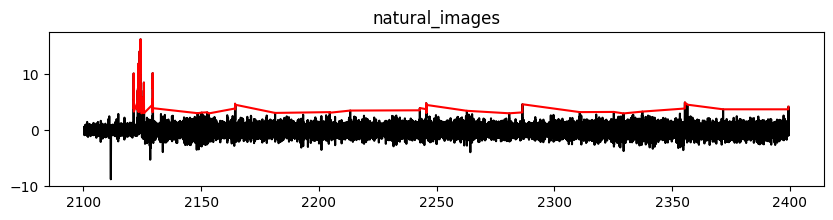

In [13]:
#Get running speed during spontaneous activity
running_speed = sess.get_running_speed()
running_mask =  running_speed > 3

rs = running_speed.sel(time=slice(tStart, tEnd))
rs_mask = rs > 3

#Create mask aligned to dff trace timestamps
#check fraction of bins within sliding 250ms window where the animal is running
tWindow = 0.250
running_mask_dff = np.zeros(ts.shape)

for ii, t in enumerate(ts):
    tmp = np.array(running_mask.sel(time=slice(t-tWindow/2,t+tWindow/2)))
    frac_running = np.sum(tmp)/len(tmp)
    
    if frac_running >= 0.7:
        running_mask_dff[ii] = 1
    elif frac_running <= 0.3:
        running_mask_dff[ii] = 0
    else: 
        running_mask_dff[ii] = -1

ts_tmp = rs.coords['time'].values
fig, ax = plt.subplots(figsize=(10,2))
ax.set_title(stimulus)
plt.plot(ts_tmp,rs,'-k')


mask = np.where(rs_mask == 1)[0]
plt.plot(ts_tmp[mask],rs.sel(time=ts_tmp[mask]),'-r')
for iR, rstr in enumerate(['Rest','Running']):
    frac = np.sum(running_mask_dff == iR)*100/running_mask_dff.shape[0]
    print(f'{rstr}: {frac:.1f} %')

In [35]:

ray.shutdown()

In [14]:
ray.init(include_dashboard=True)

# num_ticks = 101
# pb = ProgressBar(num_ticks)
# actor = pb.actor

FC_cascade, FC_cascade_shf, pval_cascade = calculate_correlation(data, running_mask_dff, 'shuffle')# (pb,actor))

ray.shutdown()

2023-03-22 17:32:49,356	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


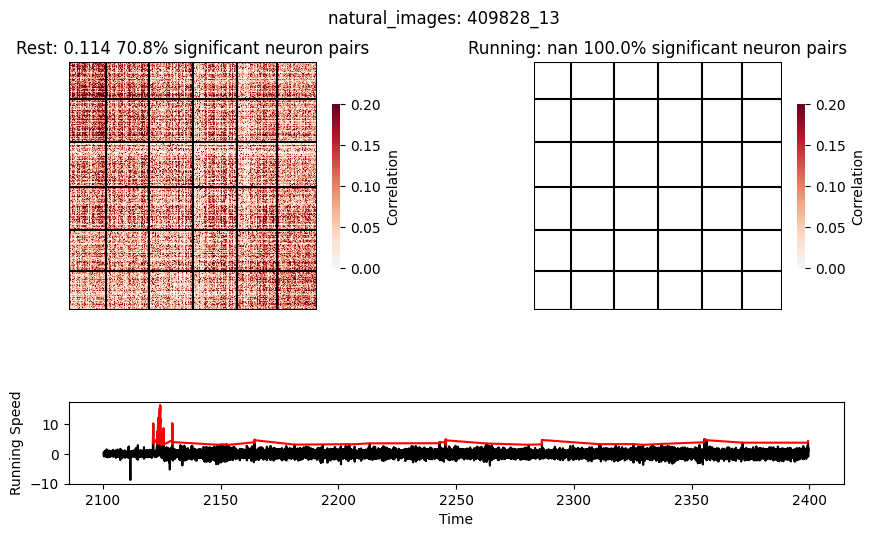

In [15]:

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig,wspace=0.5,hspace=.25,height_ratios=[8,2])

#Get running speed during spontaneous activity
running_speed = sess.get_running_speed()
running_mask =  running_speed > 3

rs = running_speed.sel(time=slice(tStart, tEnd))
rs_mask = rs > 3

#Create mask aligned to dff trace timestamps
#check fraction of bins within sliding 250ms window where the animal is running
tWindow = 0.250
running_mask_dff = np.zeros(ts.shape)

for ii, t in enumerate(ts):
    tmp = np.array(running_mask.sel(time=slice(t-tWindow/2,t+tWindow/2)))
    frac_running = np.sum(tmp)/len(tmp)
    
    if frac_running >= 0.7:
        running_mask_dff[ii] = 1
    elif frac_running <= 0.3:
        running_mask_dff[ii] = 0
    else: 
        running_mask_dff[ii] = -1

ax = fig.add_subplot(gs0[1,:])
ts_tmp = rs.coords['time'].values

ax.plot(ts_tmp,rs,'-k')
mask = np.where(rs_mask == 1)[0]
ax.plot(ts_tmp[mask],rs.sel(time=ts_tmp[mask]),'-r')
ax.set_xlabel('Time')
ax.set_ylabel('Running Speed')

plt.suptitle(f'{stimulus}: {mouse_id}_{col}{vol}',y=0.9)
FC = FC_cascade; pval = pval_cascade
N = FC.shape[-1]
boundaries =  np.concatenate(([0],np.cumsum(nNeurons_plane)))
for jj, rstr in enumerate(['Rest','Running']):
    ax = fig.add_subplot(gs0[0,jj])
    mask = (pval[jj] > 0.05) # | (FC[jj] < 0)
    vmax = np.round(np.nanpercentile(FC,95),1)
    vmin = np.round(np.nanpercentile(FC,5),1)
    sns.heatmap(FC[jj],ax=ax,cbar=True,square=True,cbar_kws={'shrink':0.5,'label': 'Correlation'},vmin=vmin,vmax=vmax,cmap='RdBu_r',center=0)
    ax.axis('off')

    percent_sig = (np.sum(~mask)- N)*100/(N**2-N)
    ax.set_title(f'{rstr}: {np.nanmean(FC[jj,~mask].ravel()):.3f} {percent_sig:.1f}% significant neuron pairs')
    ax.vlines(boundaries,*ax.get_ylim(),color='k')
    ax.hlines(boundaries,*ax.get_ylim(),color='k')

    ticks = boundaries[:-1] + np.diff(boundaries)/2
    ax.set_xticks(ticks); ax.set_yticks(ticks)
    ax.set_xticklabels([f'Plane {i}' for i in range(1,7)])
    ax.set_yticklabels([f'Plane {i}' for i in range(1,7)])

# ax = fig.add_subplot(gs0[0,-1])

# sns.histplot(FC[0].ravel(),kde=True,ax=ax,stat='density',label='Rest')
# sns.histplot(FC[1].ravel(),kde=True,ax=ax,stat='density',label='Running')
# ax.legend()
plt.savefig(os.path.join(PlotDir,f'correlation_{stimulus}_{mouse_id}_{col}{vol}.png'))

In [16]:
DF_SAVE_DIR = r"/home/david.wyrick/projects/V1DD/results/correlation"

np.savez(os.path.join(DF_SAVE_DIR,f'correlation_matrices_{stimulus}_m{mouse_id}_{col}{vol}_{stimulus}.npz'), 
         FC=FC_cascade,pval=pval_cascade,FC_shf=FC_cascade_shf)


In [ ]:
ray.init(include_dashboard=True, dashboard_port=5432)

num_ticks = 2
pb = ProgressBar(num_ticks)
actor = pb.actor

data_array = spike_prob[:,33:-32]
running_mask = running_mask_dff[33:-32]
N, T = data_array.shape


FC_cascade2, _, _ = calculate_correlation(data_array, running_mask, (pb,actor),shuffle=False,subtract_mean=True)

ray.shutdown()

In [ ]:
boundaries =  np.concatenate(([0],np.cumsum(nNeurons_plane)))

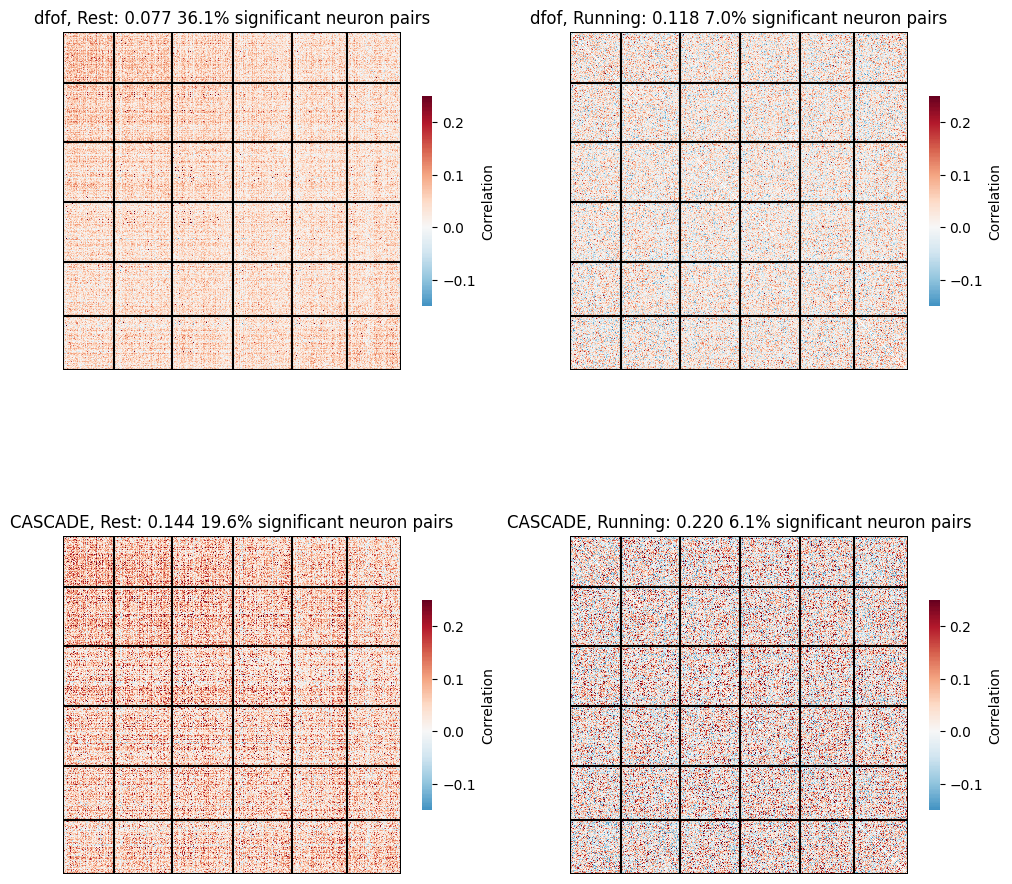

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
title_strs = ['dfof','CASCADE']
N = pval_cascade.shape[1]
pval_list = [pval_dff,pval_cascade]
for ii, FC in enumerate([FC_dff, FC_cascade]):
    pval = pval_list[ii]
    for jj, rstr in enumerate(['Rest','Running']):
        mask = (pval[jj] > 0.05) | (FC[jj] < 0)
        sns.heatmap(FC[jj],ax=axes[ii,jj],cbar=True,square=True,cbar_kws={'shrink':0.5,'label': 'Correlation'},vmin=-0.15,vmax=0.25,cmap='RdBu_r',center=0)
        axes[ii,jj].axis('off')

        percent_sig = (np.sum(~mask)- N)*100/(N**2-N)
        axes[ii,jj].set_title(f'{title_strs[ii]}, {rstr}: {np.nanmean(FC[jj,~mask].ravel()):.3f} {percent_sig:.1f}% significant neuron pairs')

        ax = axes[ii,jj]
        ax.vlines(boundaries,*ax.get_ylim(),color='k')
        ax.hlines(boundaries,*ax.get_ylim(),color='k')

    # sns.histplot(FC[iR].ravel(),ax=axes[iR],color=cc[iR])


In [ ]:
N

2

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
title_strs = ['dfof','CASCADE']

pval_list = [pval_dff,pval_cascade]
for ii, FC in enumerate([FC_dff, FC_cascade]):
    pval = pval_list[ii]
    for jj, rstr in enumerate(['Rest','Running']):
        mask = pval[jj] > 0.05
        sns.kdeplot(FC[jj,mask].ravel(),color=cc[jj],ax=axes[ii],label=rstr)
        axes[ii].set_title(f'{title_strs[ii]}')
        axes[ii].legend() 
    
    # sns.histplot(FC[iR].ravel(),ax=axes[iR],color=cc[iR])


In [ ]:
pval_list = [pval_dff,pval_cascade]
for ii, FC in enumerate([FC_dff, FC_cascade]):

In [ ]:
DF_SAVE_DIR = r"/home/david.wyrick/Git/allen_v1dd/data_frames"

np.savez(path.join(DF_SAVE_DIR,f'correlation_matrices_m{mouse_id}_{col}{vol}_20230301.npz'), 
         FC_dff=FC_dff,FC_cascade=FC_cascade,pval_cascade=pval_cascade,pval_dff=pval_dff,
         FC_dff_shf=FC_dff_shf,FC_cascade_shf=FC_cascade_shf)

In [ ]:
DF_SAVE_DIR = r"/home/david.wyrick/Git/allen_v1dd/data_frames"

results = np.load(path.join(DF_SAVE_DIR,f'correlation_matrices_surrogate_shf_m{mouse_id}_{col}{vol}.npz'))
FC_cascade = results['FC_cascade']
# FC_cascade_shf = results['FC_cascade_shf']
pval_cascade = results['pval_cascade']

results.close()
results = np.load(path.join(DF_SAVE_DIR,f'correlation_matrices_m{mouse_id}_{col}{vol}_20230301.npz'))
FC_dff = results['FC_dff']
# FC_dff_shf = results['FC_dff_shf']
pval_dff = results['pval_dff']
results.close()

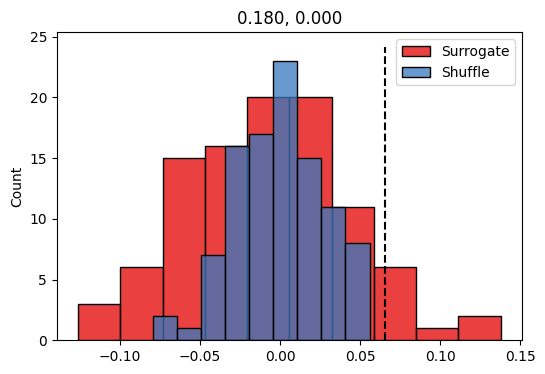

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

iR = 0; i = 0; j = 10
sns.histplot(FC_cascade_shf[iR,:,i,j],color=cc[1],ax=ax,label='Surrogate')
sns.histplot(FC_cascade_shf2[iR,:,i,j],color=cc[2],ax=ax,label='Shuffle')

ax.vlines(FC_cascade[iR,i,j],*ax.get_ylim(),ls='--',color='k')

ax.set_title(f'{pval_cascade[iR,i,j]:.3f}, {pval_cascade2[iR,i,j]:.3f}')
ax.legend()



## Network topology using the adjacency matrix A_ij.

In [ ]:
pval_list = [pval_dff,pval_cascade]
for ii, FC in enumerate([FC_dff, FC_cascade]):
    pval = pval_list[ii]
    for jj, rstr in enumerate(['Rest','Running']):
        mask = (pval[jj] < 0.05) & (FC[jj] > 0)

        percent_sig = (np.sum(mask)- N)*100/(N**2-N)
        print(f'{title_strs[ii]}, {rstr}: {np.nanmean(FC[jj,mask].ravel()):.3f} {percent_sig:.1f}% significant neuron pairs')


Rest: Connectivity strength = 0.141; Connectivity diversity = 0.003
	7.299640e+05 significant neuron pairs
Running: Connectivity strength = 0.140; Connectivity diversity = 0.027
	2.865920e+05 significant neuron pairs


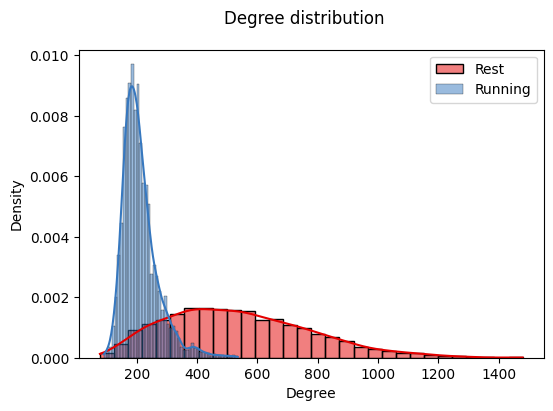

In [ ]:
rstrs = ['Rest','Running']

fig, ax = plt.subplots(figsize=(6,4))
plt.suptitle('Degree distribution')

graph_list = []
results_dict = {rstr: {} for rstr in ['Rest','Running']}

for iR, (FC, pval,rstr) in enumerate(zip(FC_cascade,pval_cascade,['Rest','Running'])):
    #Define connected neurons if they have a positive significant correlation
    adjacency_mat = np.array((pval < 0.05),dtype=int)
    mask = (pval_cascade[iR] < 0.05)# & (FC_cascade[iR] > 0)
    
    #Crates graph using the data of the adjacency matrix
    G = nx.Graph(adjacency_mat)
    graph_list.append(G)

    #Basic correlation measures
    connectivity_strength = np.mean(FC[np.triu(mask,1)].ravel())
    connectivity_diversity = np.var(FC[np.triu(mask,1)].ravel())
    results_dict[rstr]['connectivity_strength'] = connectivity_strength
    results_dict[rstr]['connectivity_diversity'] = connectivity_diversity

    print(f'{rstr}: Connectivity strength = {connectivity_strength:.3f}; Connectivity diversity = {connectivity_diversity:.3f}')
    print(f'\t{np.sum(mask)/2:e} significant neuron pairs')

    #Get degree distribution
    degree_dist = list(dict(G.degree()).values())
    results_dict[rstr]['degree_dist'] = degree_dist
    
    sns.histplot(degree_dist,ax=ax,color=cc[iR+1],label=rstr,kde=True,stat='density')
    plt.xlabel('Degree')

ax.legend()

In [ ]:

#Get degree assortativity
#"Assortativity in a network refers to the tendency of nodes to connect with other ‘similar’ nodes over ‘dissimilar’ nodes."
#Here that is the degree of a node
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    DAC = nx.degree_assortativity_coefficient(G)
    results_dict[rstr]['DAC'] = DAC
    print(f'{rstr}: Degree assortativity coefficient = {DAC:.3f}')



Rest: Degree assortativity coefficient = 0.082
Running: Degree assortativity coefficient = 0.266


In [ ]:

#Compute graph transitivity, the fraction of all possible triangles present in G.
#Measure of clustering
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    transitivity = nx.transitivity(G)
    results_dict[rstr]['transitivity'] = transitivity
    print(f'{rstr}: Graph transitivity = {transitivity:.3f}')



Rest: Graph transitivity = 0.334
Running: Graph transitivity = 0.196


In [ ]:

#Calculate global efficiency 
# The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. 
# The average global efficiency of a graph is the average efficiency of all pairs of nodes
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    ge = nx.global_efficiency(G)
    results_dict[rstr]['global_efficiency'] = ge
    print(f'{rstr}: Global efficiency = {ge:.3f}')



Rest: Global efficiency = 0.598
Running: Global efficiency = 0.526


In [ ]:

#Calculate local efficiency 
# The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. 
# The local efficiency of a node in the graph is the average global efficiency of the subgraph induced by the neighbors of the node. The average local efficiency is the average of the local efficiencies of each node [1].
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    le = nx.local_efficiency(G)
    results_dict[rstr]['local_efficiency'] = le
    print(f'{rstr}: Local efficiency = {le:.3f}')





KeyboardInterrupt: 

In [ ]:

#Calculate whether the network is "whole" or disjointed into multiple subnetworks
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    nC = nx.number_connected_components(G)
    results_dict[rstr]['number_connected_components'] = nC
    print(f'{rstr}: number_connected_components = {nC:.3f}')



Rest: number_connected_components = 1.000
Running: number_connected_components = 1.000


In [ ]:
#Small-worldness sigma
#A graph is commonly classified as small-world if sigma>
for iR, (G,rstr) in enumerate(zip(graph_list,['Rest','Running'])):
    sigma = nx.sigma(G,niter=1,nrand=1)
    results_dict[rstr]['sigma'] = sigma
    print(f'{rstr}: Small-worldness sigma = {nC:.3f}')



KeyboardInterrupt: 

In [ ]:
#Find communities 
module_list = list(naive_greedy_modularity_communities(G))

#Calculate modularity
Q = nx_comm.quality.modularity(G,module_list)
nMods = len(module_list)

KeyboardInterrupt: 

In [ ]:
if nC == 1:
    #Small-worldness sigma
    sigma = nx.sigma(G,niter=1,nrand=1)
else:
    sigma = np.nan

In [ ]:
@ray.remote
def sub_fcn2(FC, pval):
    
    corr_threshold = 0
    mask = (~np.isnan(FC)) & (pval < 0.05) & (FC > corr_threshold)
    if np.sum(mask) == 0:
        return (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)

    # cost = 1
    # #Obtain correlation threshold for a particular cost
    # while cost > cost_threshold:
    #     mask = (~np.isnan(FC)) & (pval < 0.05) & (FC > corr_threshold)
    #     cost = np.sum(np.triu(mask,1)) / ((N**2 - N)/2)
    #     corr_threshold += 0.001
    
    # cost = np.sum(np.triu(mask,1)) / ((N**2 - N)/2)
    connectivity_strength = np.mean(FC[np.triu(mask,1)].ravel())
    connectivity_diversity = np.var(FC[np.triu(mask,1)].ravel())

    adjacency_mat = np.array((pval < 0.05) & (FC > corr_threshold),dtype=int)
    #Crates graph using the data of the adjacency matrix
    G = nx.Graph(adjacency_mat)

    #Get degree distribution
    degree_dist = list(dict(G.degree()).values())

    #Get degree assortativity
    DAC = nx.degree_assortativity_coefficient(G)
    
    #Compute graph transitivity, the fraction of all possible triangles present in G.
    transitivity = nx.transitivity(G)

    #Calculate global efficiency 
    ge = nx.global_efficiency(G)
    
    #Calculate local efficiency 
    le = nx.local_efficiency(G)
    
    #Calculate whether the network is "whole" or disjointed into multiple subnetworks
    nC = nx.number_connected_components(G)
    
#     #Find communities 
#     module_list = list(naive_greedy_modularity_communities(G))

#     #Calculate modularity
#     Q = nx_comm.quality.modularity(G,module_list)
#     nMods = len(module_list)

    Q = np.nan
    nMods = np.nan
      
#     sigma = np.nan
    if nC == 1:
        #Small-worldness sigma
        sigma = nx.sigma(G,niter=1,nrand=1)
    else:
        sigma = np.nan

    

    return (connectivity_strength,connectivity_diversity,DAC,transitivity,ge,cost,corr_threshold,nC,sigma,le,Q,nMods)

def targeted_attack(G):

    steps = 0
    centrality = nx.betweenness_centrality(G)
    centrality_dist = list(centrality.values())
    N = len(centrality_dist)
    indices = np.argsort(centrality_dist)[::-1]
#     pdb.set_trace()
    while nx.is_connected(G):
        G.remove_node(indices[steps])
        steps += 1
        if steps +1 == N:
            return steps
    else:
        return steps

def random_attack(G):
    steps = 0

    while nx.is_connected(G):
        if len(G.nodes()) < 1:
            return steps
        node = np.random.choice(G.nodes())
        G.remove_node(node)
        steps += 1
    else:
        return steps

In [ ]:
ray.init(include_dashboard=True)

task_pre_launch = []
for jj, rstr in enumerate(['Rest','Running']):
    FC = FC_cascade[iR]; pval = pval_cascade[iR]
    task_pre_launch.append(sub_fcn2.remote(FC, pval))
results_list = ray.get(task_pre_launch)

ray.shutdown()

In [ ]:
import h5py
h5path = '/home/david.wyrick/projects/V1DD/results/networkx_results.h5'
with h5py.File(h5path,'w') as h5file:
    h5file.create_dataset('networkx_list',data=results_list)  


In [ ]:
print('Done')

In [ ]:
ray.shutdown()

In [ ]:
#Perform targeted attack
steps = targeted_attack(G.copy())
frac_nodes_targeted = steps/N

#Perform random attack
tmp_list = []
for iRand in range(100):
#                 steps = random_attack(G.copy())
    steps = 0
    Gr = G.copy()
    while nx.is_connected(Gr):
        if len(Gr.nodes()) <= 1:
            break
        node = np.random.choice(Gr.nodes())
        Gr.remove_node(node)
        steps += 1
    tmp_list.append(steps)

frac_nodes_random = np.mean(tmp_list)/N